## Name: Krishnakanth N.
## Index No: 190323C

In [196]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cv2 as cv

### Q1)

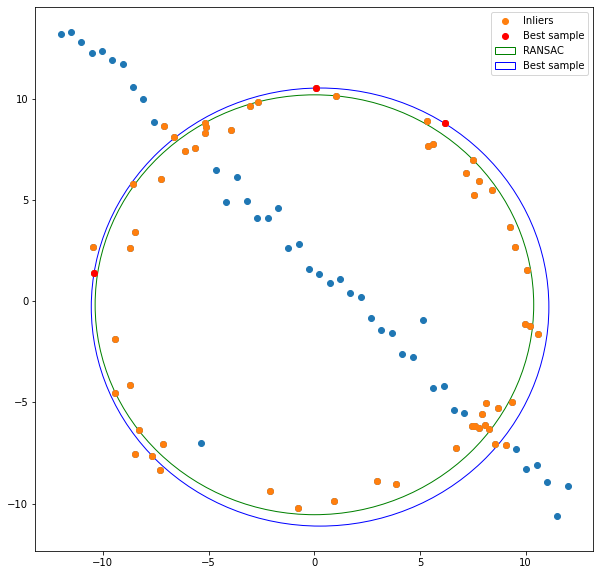

In [195]:
N = 100
half_n = N//2

R = 10
s = R/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)

x ,y = (R + n)*np.cos(t), (R + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X[:,0], X[:, 1], 'o')

def generatePoints(points, n):
    count = 0
    sample = []
    while count < n:
        x,y = points[np.random.randint(len(points))]        
        if (x,y) not in sample:
            sample.append((x,y))
            count += 1
    return sample

def drawCircle(sample):
    p1 = sample[0]
    p2 = sample[1]
    p3 = sample[2]
    A = np.array([[p2[0] - p1[0], p2[1] - p1[1]], [p3[0] - p2[0], p3[1] - p2[1]]]) 
    B = np.array([[p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2], [p3[0]**2 - p2[0]**2 + p3[1]**2 - p2[1]**2]])		
    inv_A = inv(A)
    x_c, y_c = np.dot(inv_A, B) / 2
    x_c, y_c = x_c[0], y_c[0]
    r = np.sqrt((x_c - p1[0])**2 + (y_c - p1[1])**2)

    return (x_c, y_c, r)

def inlierAndError(circle, points, threshold):
    x_points = points[:, 0]
    y_points = points[:, 1]
    x_c, y_c, r = circle
    total_error = 0
    inliers = []

    for i in range(len(x_points)):
        error = np.sqrt((x_points[i] - x_c)**2 + (y_points[i] - y_c)**2)
        if abs(error - r) <= threshold:
            inliers.append([x_points[i], y_points[i]])
            total_error += abs(error - r)  

    return inliers, total_error

x_points = X[:, 0]
y_points = X[:, 1]
iterations = 100
threshold_error = R/8
threshold_inlier_count = 40
best_model = [0, 0, [], 10000000, []]

for i in range(iterations):
    sample = generatePoints(X, 3)
    initial_circle = drawCircle(sample)

    if abs(R - initial_circle[2]) > 1.2*R:
        continue

    inliers, total_error = inlierAndError(initial_circle, X, threshold_error)

    if len(inliers) < threshold_inlier_count:
        continue

    inlier_sample = generatePoints(inliers, 3)
    new_circle = drawCircle(inlier_sample)
    new_inliers, new_total_error = inlierAndError(new_circle, X, threshold_error)

    if len(new_inliers) < threshold_inlier_count:
        continue

    if (len(best_model[-1]) < len(new_inliers)) or ((len(best_model[-1]) == len(new_inliers)) and (best_model[3] > new_total_error)):
        best_model = [new_circle, initial_circle, sample, new_total_error, new_inliers]

inliers = np.array(best_model[-1])
best_samples = np.array(best_model[2])

ax.plot(inliers[:, 0], inliers[:, 1], 'o', label='Inliers')
ax.plot(best_samples[:,0], best_samples[:, 1], 'o', color='r', label='Best sample')

x_c, y_c, r = best_model[0][0], best_model[0][1], best_model[0][2]
new_circle = Circle((x_c, y_c), radius=r, color='g', fc='y', fill=False, label='RANSAC')
ax.add_patch(new_circle)

x_c, y_c, r = best_model[1][0], best_model[1][1], best_model[1][2]
initial_circle = Circle((x_c, y_c), radius=r, color='b', fc='y', fill=False, label='Best sample')
ax.add_patch(initial_circle)

ax.legend();

### Q2)

(400, 800, 3)
(400, 800, 3)


(-0.5, 1023.5, 767.5, -0.5)

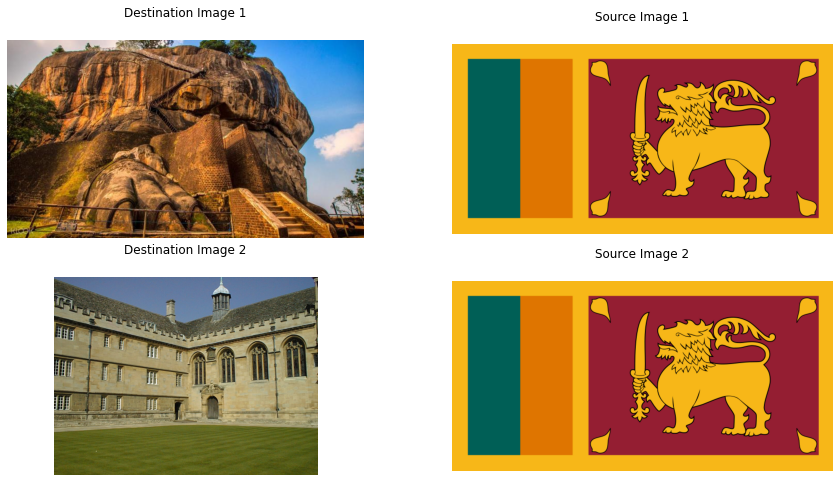

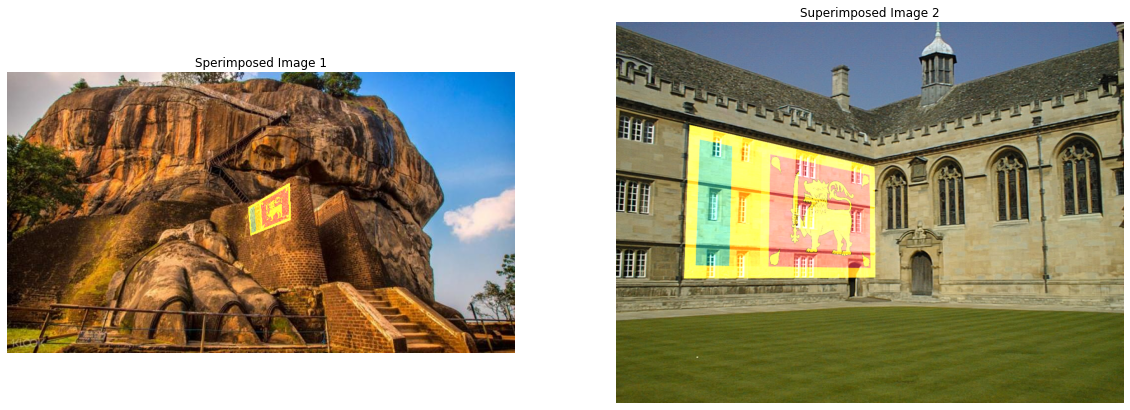

In [228]:
dst1 = cv.imread(r'sigiriya.jpg',cv.IMREAD_COLOR)
assert dst1 is not None

src1 = cv.imread(r'lk_flag.png',cv.IMREAD_ANYCOLOR)
assert src1 is not None

dst2 = cv.imread(r'001.jpg',cv.IMREAD_COLOR)
assert dst2 is not None

src2 = cv.imread(r'lk_flag.png',cv.IMREAD_ANYCOLOR)
assert src2 is not None

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0, 0].imshow(cv.cvtColor(dst1, cv.COLOR_BGR2RGB))
ax[0, 0].title.set_text('Destination Image 1')
ax[0, 0].axis('off')
ax[0, 0].xaxis.tick_top()

ax[0, 1].imshow(cv.cvtColor(src1, cv.COLOR_BGR2RGB))
ax[0, 1].title.set_text('Source Image 1')
ax[0, 1].axis('off')
ax[0, 1].xaxis.tick_top()

ax[1, 0].imshow(cv.cvtColor(dst2, cv.COLOR_BGR2RGB))
ax[1, 0].title.set_text('Destination Image 2')
ax[1, 0].axis('off')
ax[1, 0].xaxis.tick_top()

ax[1, 1].imshow(cv.cvtColor(src2, cv.COLOR_BGR2RGB))
ax[1, 1].title.set_text('Source Image 2')
ax[1, 1].axis('off')
ax[1, 1].xaxis.tick_top()

def click_event(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, ' ', y)

def superimpose(im_src, im_dst, pts_src, pts_dst):
    h, status = cv.findHomography(pts_src, pts_dst)
    im_out = cv.warpPerspective(im_src, h, (im_dst.shape[1], im_dst.shape[0]))
    return cv.add(im_out, im_dst)

cv.imshow('image', dst1)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()

cv.imshow('image', dst2)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()

pts_dst2 = np.array([[148, 207], [521, 292], [523, 515], [137, 517]])
pts_dst1 = np.array([[379, 214], [445, 175],  [447, 234], [383, 259]])

print(src1.shape)
print(src2.shape)

pts_src1 = np.array([[0, 0], [800, 0], [800, 400], [0, 400]])
pts_src2 = np.array([[0, 0], [800, 0], [800, 400], [0, 400]])

superimposed1 = superimpose(src1, dst1, pts_src1, pts_dst1)
superimposed2 = superimpose(src2, dst2, pts_src2, pts_dst2)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv.cvtColor(superimposed1, cv.COLOR_BGR2RGB))
ax[0].set_title('Sperimposed Image 1')
ax[0].axis('off')

ax[1].imshow(cv.cvtColor(superimposed2, cv.COLOR_BGR2RGB))
ax[1].set_title('Superimposed Image 2')
ax[1].axis('off')

### Q3)

### a)

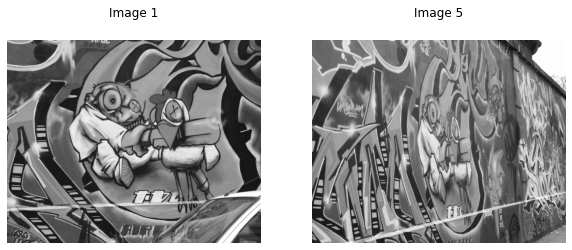

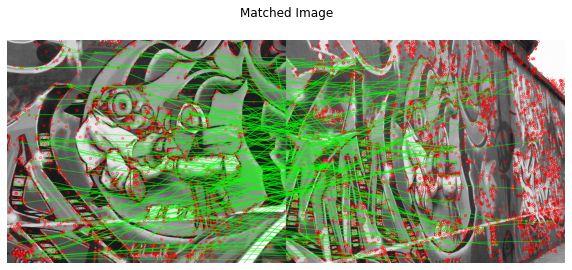

In [248]:
img1 = cv.imread(r'img1.ppm', cv.IMREAD_GRAYSCALE)
assert img1 is not None

img5 = cv.imread(r'img5.ppm', cv.IMREAD_GRAYSCALE)
assert img5 is not None

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap = 'gray', vmin = 0, vmax = 255)
ax[0].title.set_text('Image 1')
ax[0].axis('off')
ax[0].xaxis.tick_top()

ax[1].imshow(img5, cmap = 'gray', vmin =0, vmax=255)
ax[1].title.set_text('Image 5')
ax[1].axis('off')
ax[1].xaxis.tick_top()

 # Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img5, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k = 2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i] = [1,0]

draw_params = dict(matchColor = (0, 255, 0),
                singlePointColor = (255, 0, 0),
                matchesMask = matchesMask,
                flags = cv.DrawMatchesFlags_DEFAULT)
                
img3 = cv.drawMatchesKnn(img1, kp1, img5, kp2, matches, None, **draw_params)

fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img3, cmap = 'gray', vmin = 0, vmax = 255)
ax.title.set_text('Matched Image')
ax.axis('off')
ax.xaxis.tick_top()

### b)

In [249]:
H0 = np.identity(3)

for i in range(4):
    src_name = str(i + 1)+'.ppm'
    src_img = cv.imread(r'img'+src_name, cv.IMREAD_GRAYSCALE)
    assert src_img is not None

    dst_name = str(i + 2)+'.ppm'
    dst_img = cv.imread(r'img'+dst_name, cv.IMREAD_GRAYSCALE)
    assert dst_img is not None

    # Initiate SIFT detector
    sift = cv.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(src_img, None)
    kp2, des2 = sift.detectAndCompute(dst_img, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k = 2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    # print(len(good))

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 0.95)

    H0 = np.matmul(H, H0)

print(H0)

[[ 6.22594685e-01  6.32229252e-02  2.20364448e+02]
 [ 2.20156353e-01  1.16389696e+00 -2.57695451e+01]
 [ 4.88791378e-04 -2.87804193e-05  9.95040822e-01]]


### Q3)

(-0.5, 1599.5, 1279.5, -0.5)

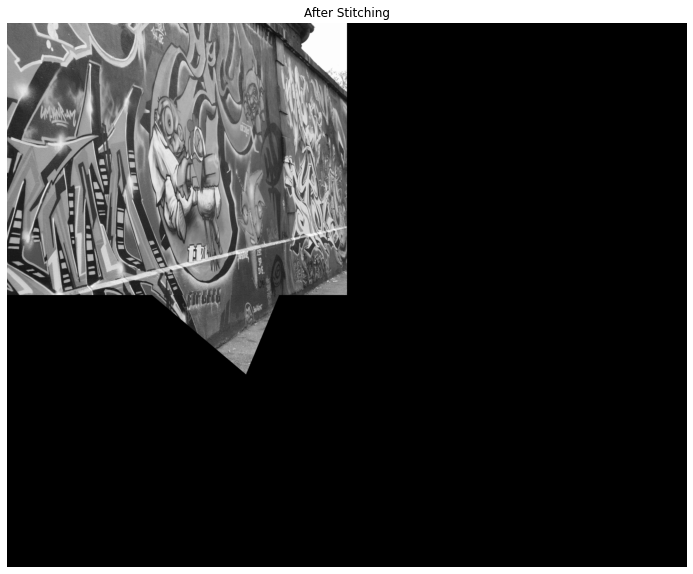

In [250]:
dst = cv.warpPerspective(src_img, H, (dst_img.shape[1] + src_img.shape[1], dst_img.shape[0] + src_img.shape[0])) 

#paste them together
dst[0:dst_img.shape[0], 0:dst_img.shape[1]] = dst_img

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(dst, cmap = 'gray', vmin = 0, vmax = 255)
ax.set_title('After Stitching')
ax.axis('off')